
# 4. Image-Based Lighting


## Recovering HDR Radiance Maps 

Load libraries and data

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
# System imports
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

datadir = "/Users/marchon/Downloads/proj4/"

utilfn = datadir + "utils"
!cp -r "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .

import utils
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter



### Reading LDR images

In [7]:
imfns = ['s10.png', 's40.png', 's160.png']
exposure_times = [1/10.0, 1/40.0, 1/160.0]

ldr_images = []
for f in np.arange(len(imfns)):
    im = read_image(datadir + "samples/" + imfns[f])
    if f==0:
        imsize = int((im.shape[0] + im.shape[1])/2) # set width/height of ball images
#         print(f"the image size is: {imsize}")
        ldr_images = np.zeros((len(imfns), imsize, imsize, 3))
    ldr_images[f] = cv2.resize(im, (imsize, imsize))

background_image_file = datadir + "samples/" + '0_scene.JPG'
background_image = read_image(background_image_file)
# all_ones = np.all(ldr_images[0] == 1)
# print(all_ones)

### Naive LDR merging 

Compute the HDR image as average of irradiance estimates from LDR images

In [271]:
def make_hdr_naive(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    The steps to implement:
    1) Divide each image by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    2) Return average of above images
      
    Args:
        ldr_images(np.ndarray): N x H x W x 3  shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            naive ldr merging implementation.
        (np.ndarray): N x H x W x 3  shaped numpy array represending log irradiances
            for each exposures        
    '''
    N, H, W, C = ldr_images.shape
    assert N == len(exposures)

    hdr_image = np.zeros((H, W, C), dtype=np.float32)
    log_irradiances = np.zeros((N, H, W, C), dtype=np.float32)
    
    for i in range(N):
        hdr_image += (ldr_images[i] * 255) / (exposures[i] + 1e-6)
        log_irradiances[i] = np.log((ldr_images[i] * 255 + 0.1) / (exposures[i] + 1e-6))
        
    hdr_image /= N
    return hdr_image, log_irradiances

In [272]:
def display_hdr_image(im_hdr):
    '''
    Maps the HDR intensities into a 0 to 1 range and then displays. 
    Three suggestions to try: 
      (1) Take log and then linearly map to 0 to 1 range (see display.py for example) 
      (2) img_out = im_hdr / (1 + im_hdr)
      (3) HDR display code in a python package 
    '''
    img_out = np.log(im_hdr)
    img_out = rescale_images_linear(img_out)
    plt.imshow(img_out)
    
    return img_out

HDR Image


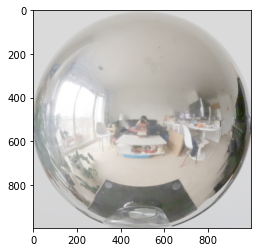

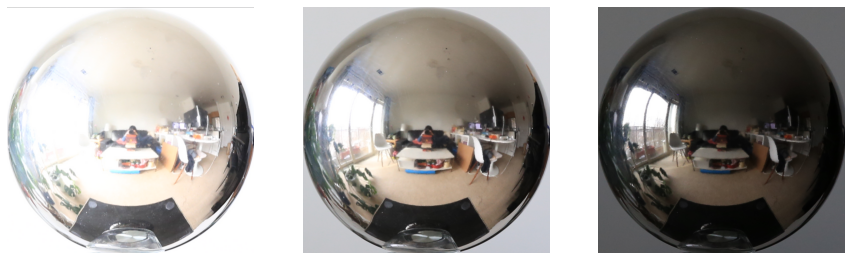

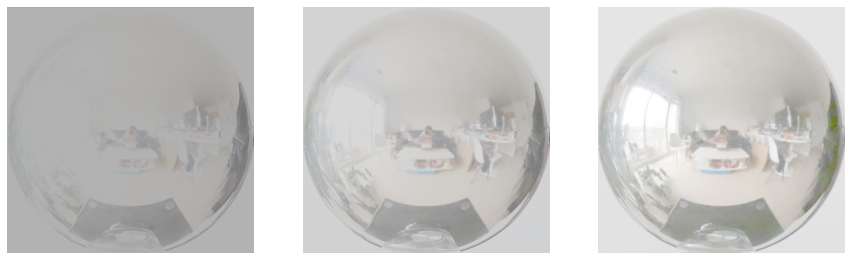

In [273]:

# get HDR image, log irradiance
naive_hdr_image, naive_log_irradiances = make_hdr_naive(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(naive_hdr_image, datadir + 'naive_hdr.hdr')

# display HDR image
print('HDR Image')
display_hdr_image(naive_hdr_image)

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(naive_log_irradiances)



### Weighted LDR merging 

Compute HDR image as a weighted average of irradiance estimates from LDR images, where weight is based on pixel intensity so that very low/high intensities get less weight


In [282]:
def make_hdr_weighted(ldr_images: np.ndarray, exposure_times: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) compute weights for images with based on intensities for each exposures
        - This can be a binary mask to exclude low / high intensity values

    2) Divide each images by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    3) Return weighted average of above images
    
    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposure_times(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged without
            under - over exposed regions

    '''
    N, H, W, C = ldr_images.shape
    assert N == len(exposure_times)

    hdr_image = np.zeros((H, W, C), dtype=np.float32)
    weights_sum = np.zeros((H, W, C), dtype=np.float32)
    log_irradiances = np.zeros((N, H, W, C), dtype=np.float32)
    w = lambda z: (128 - np.abs(z - 128)) #assuming pixel values range in [0,255]
   
    for i in range(N):
        curr_weights = w(ldr_images[i] * 255)
        weights_sum += curr_weights
        hdr_image += (curr_weights * ldr_images[i] * 255) / (exposure_times[i] + 1e-6)
        log_irradiances[i] = np.log((w(ldr_images[i] * 255) + 0.1) / (exposure_times[i] + 1e-6))
        
    hdr_image /= (weights_sum + 1e-6)
    log_irradiances /= (weights_sum + 1e-6)
    
    return hdr_image, log_irradiances

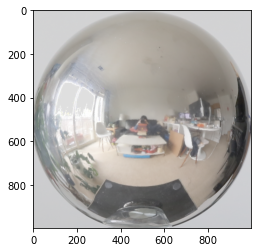

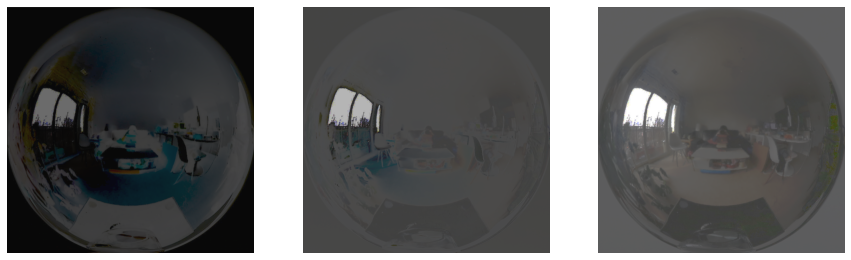

In [283]:
# get HDR image, log irradiance
weighted_hdr_image, weighted_log_irradiances = make_hdr_weighted(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(weighted_hdr_image, datadir + 'weighted_hdr.hdr')

# display HDR image
display_hdr_image(weighted_hdr_image)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(weighted_log_irradiances)

Display of difference between naive and weighted for your own inspection

Where does the weighting make a big difference increasing or decreasing the irradiance estimate?  Think about why.

Min ratio =  0.60611665   Max ratio =  2.0583541


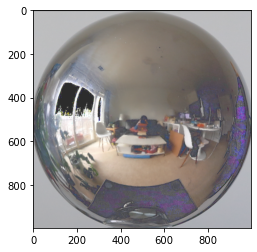

In [240]:
# display difference between naive and weighted 

log_diff_im = np.log(weighted_hdr_image)-np.log(naive_hdr_image)
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

### LDR merging with camera response function estimation 

Compute HDR after calibrating the photometric reponses to obtain more accurate irradiance estimates from each image

Some suggestions on using <tt>gsolve</tt>:
<ul>
	<li>When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (1000 or so can suffice), but make sure all pixel locations are the same for each exposure.</li>
	<li>The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method).</li>
	<li>Try different lambda values for recovering <i>g</i>. Try lambda=1 initially, then solve for <i>g</i> and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.</li>
	<li>Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log irradiance values, so make sure to exponentiate the result and save irradiance in linear scale.</li>
</ul>

Eq.4: The weight function $w(z)$ is defined as:

$$
w(z) = 
\begin{cases} 
z - Z_{\text{min}} & \text{for } z \leq \frac{1}{2}(Z_{\text{min}} + Z_{\text{max}}), \\
Z_{\text{max}} - z & \text{for } z > \frac{1}{2}(Z_{\text{min}} + Z_{\text{max}}).
\end{cases}
$$


where:
- $z$ is the pixel brightness value,
- $Z_{\text{min}}$ is the least pixel value,
- $Z_{\text{max}}$ is the greatest pixel value.

Eq.6 This function is used to compute the log radiance of a pixel $i$ by combining its values across $P$ different exposures. 
$$
\ln E_i = \frac{\sum_{j=1}^{P} w(Z_{ij}) (g(Z_{ij}) - \ln \Delta t_j)}{\sum_{j=1}^{P} w(Z_{ij})}
$$

where:
- $E_i$: The radiance of pixel $i$, which corresponds to the true intensity of the scene at that point.
- $\ln$: The natural logarithm.
- $Z_{ij}$: The pixel value of pixel $i$ in the $j$-th image.
- $w(Z_{ij})$: A weight assigned to $Z_{ij}$, usually a function that reduces the influence of pixels that are near saturation or underexposure.
- $g(Z_{ij})$: The camera response function applied to $Z_{ij}$. This function maps the observed pixel values to the radiance.
- $\Delta t_j$: The exposure time for the $j$-th image.
- $j$: Index for summing over the set of $P$ images.



In [195]:
def make_hdr_estimation(ldr_images: np.ndarray, exposure_times: list, lm)-> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.
    
    The gsolve operations should be ran with:
        Z: int64 array of shape N x P, where N = number of images, P = number of pixels
        B: float32 array of shape N, log shutter times
        l: lambda; float to control amount of smoothing
        w: function that maps from float intensity to weight  
    The steps to implement:
    1) Create random points to sample (from mirror ball region)
    2) For each exposures, compute g values using samples
    3) Recover HDR image using g values
    

    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
        lm (scalar): the smoothing parameter
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            gsolve
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
        (np.ndarray): 3 x 256 shaped numpy array represending g values of each pixel intensities
            at each channels (used for plotting)
    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    
    # implement HDR estimation using gsolve
    # gsolve(Z, B, l, w) -> g, lE
    
    # weighted function
    z_min, z_max = 0, 255
    w = np.clip((np.where(np.arange(256) <= (z_min + z_max) / 2, 
                       np.arange(256) - z_min, 
                       z_max - np.arange(256)) 
             / (z_max - z_min / 2)), 0.05, 0.95)
    
    hdr_image = np.zeros((H, W, C), dtype=np.float32)
    log_irradiances = np.zeros((N, H, W, C), dtype=np.float32)
    g_values = np.zeros((C, 256), dtype=np.float32)
    B = np.log(exposure_times).astype(np.float32)
    
    # prepare the mask to find the mirror ball region
    mask = np.zeros((H, W), dtype=np.uint8)
    r = round(min(H, W) / 2)
    cv2.circle(mask, (r, r), r, 1, -1)
    indices = np.argwhere(mask == 1)
    
    # create random points to sample
    selected_indices = indices[np.random.choice(len(indices), 1000, replace=False)]
    
    for c in range(C):
        Z = np.zeros((N, 1000), dtype=np.uint8)
        for n in range(N):
            Z[n] = ldr_images[n, selected_indices[:, 0], selected_indices[:, 1], c] * 255
        
        g, _= gsolve(Z, B, lm, w)
        g_values[c] = g
        
        # combining all of the exposures into a final image
        for i in range(H):
            for j in range(W):
                pixel_val = ldr_images[:, i, j, c] * 255
                weight_val = w[pixel_val.astype(int)]
                # w(z) * (g(z) - ln(dt))
                hdr_sum = np.sum(weight_val * (g[pixel_val.astype(int)] - B))
                hdr_weight_sum = np.sum(weight_val)
                
                hdr_image[i, j, c] = hdr_sum / (hdr_weight_sum + 1e-6)
                log_irradiances[:, i, j, c] = g[pixel_val.astype(int)] - B

    # exponentiate the result 
    hdr_image = np.exp(hdr_image)
    has_nan = np.isnan(hdr_image).any()
    print(f"has_nan value is: {has_nan}")
    return hdr_image, log_irradiances, g_values

has_nan value is: False


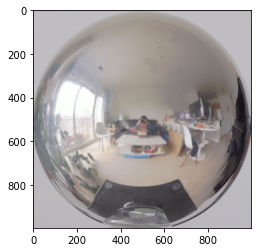

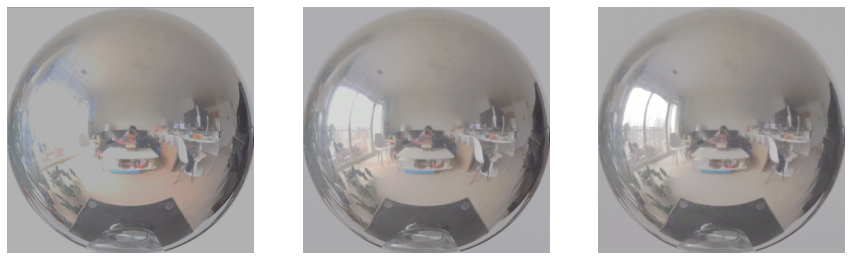

In [196]:
lm = 5
# get HDR image, log irradiance
calib_hdr_image, calib_log_irradiances, g = make_hdr_estimation(ldr_images, exposure_times, lm)

# write HDR image to directory
write_hdr_image(calib_hdr_image, datadir + 'calib_hdr.hdr')

# display HDR image
display_hdr_image(calib_hdr_image)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(calib_log_irradiances)

The following code displays your results. You can copy the resulting images and plots directly into your report where appropriate.

Min ratio =  0.31126142   Max ratio =  4.2756886


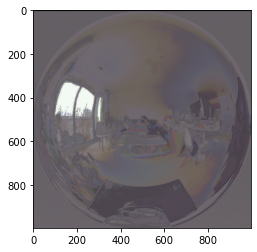

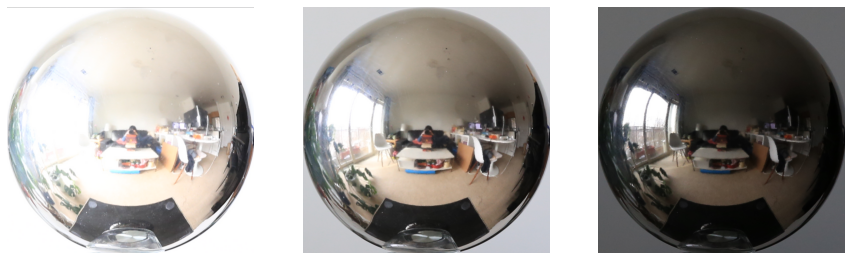

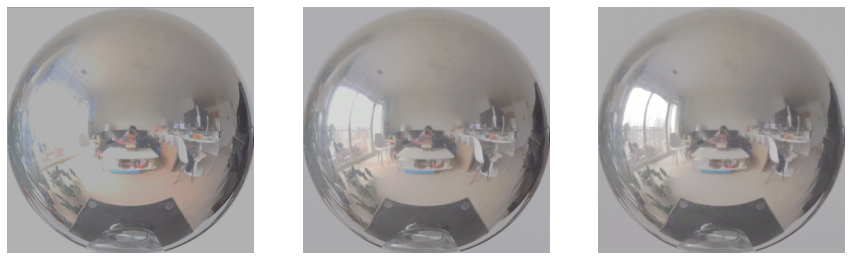

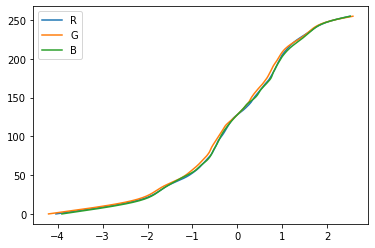

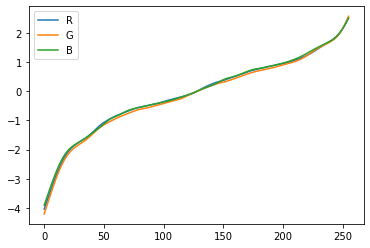

In [242]:
# display difference between calibrated and weighted
log_diff_im = np.log(calib_hdr_image/calib_hdr_image.mean())-np.log(weighted_hdr_image/weighted_hdr_image.mean())
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(calib_log_irradiances)

# plot g vs intensity, and then plot intensity vs g
N, NG = g.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(g[n], range(NG), label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

plt.figure()
for n in range(N):
    plt.plot(range(NG), g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

naive:  	log range =  4.739 	avg RMS error =  0.383
weighted:	log range =  5.377 	avg RMS error =  0.342
calibrated:	log range =  6.129 	avg RMS error =  0.144


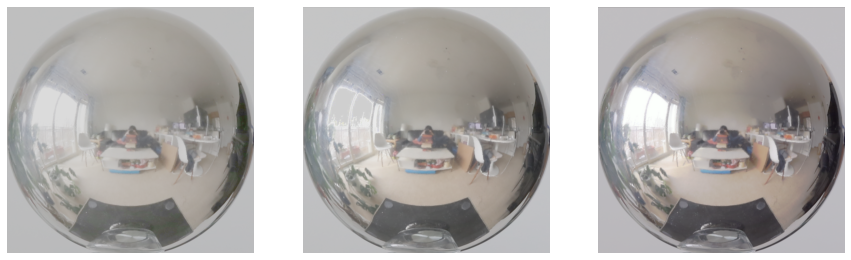

In [270]:
def weighted_log_error(ldr_images, hdr_image, log_irradiances):
  # computes weighted RMS error of log irradiances for each image compared to final log irradiance
    N, H, W, C = ldr_images.shape
    w = 1-abs(ldr_images - 0.5)*2
    err = 0
    for n in np.arange(N):
        err += np.sqrt(np.multiply(w[n], (log_irradiances[n]-np.log(hdr_image))**2).sum()/w[n].sum())/N 
    return err

# compare solutions
err = weighted_log_error(ldr_images, naive_hdr_image, naive_log_irradiances)
print('naive:  \tlog range = ', round(np.log(naive_hdr_image).max() - np.log(naive_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, weighted_hdr_image, naive_log_irradiances)
print('weighted:\tlog range = ', round(np.log(weighted_hdr_image).max() - np.log(weighted_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, calib_hdr_image, calib_log_irradiances)
print('calibrated:\tlog range = ', round(np.log(calib_hdr_image).max() - np.log(calib_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))

# display log hdr images (code provided in utils.display)
display_images_linear_rescale(np.log(np.stack((naive_hdr_image/naive_hdr_image.mean(), weighted_hdr_image/weighted_hdr_image.mean(), calib_hdr_image/calib_hdr_image.mean()), axis=0)))

## Panoramic transformations 

Compute the equirectangular image from the mirrorball image

In [199]:
def panoramic_transform(hdr_image):
    '''
    Given HDR mirror ball image, 
    
    Expects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.
    
    Steps to implement:
    1) Compute N image of normal vectors of mirror ball
    2) Compute R image of reflection vectors of mirror ball
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.
    '''
    H, W, C = hdr_image.shape
    assert H == W
    assert C == 3

    # TO DO: compute N and R
        
    # R = V - 2 * dot(V,N) * N
    j, i = np.meshgrid(np.arange(W), np.arange(H))
    x = (2 * (j / (W - 1))) - 1
    y = (2 * (i / (H - 1))) - 1

    distance_sq = x**2 + y**2
    valid_mask = distance_sq <= 1

    z = np.zeros_like(x)
    z[valid_mask] = np.sqrt(1 - distance_sq[valid_mask])

    # combining image channels with stack:
    N = np.stack((x, y, z), axis=2)
    N[~valid_mask] = 0
    has_nan = np.isnan(N).any()
    if has_nan:
        N = np.nan_to_num(N, nan=0)

    V = np.zeros_like(N)
    V[:,:,2] = -1

    # compute R image of reflection vectors of mirror ball
    R = V - 2 * (N * V).sum(-1)[..., np.newaxis] * N

    plt.imshow((N+1)/2)
    plt.show()
    plt.imshow((R+1)/2)
    plt.show()

    equirectangular_image = get_equirectangular_image(R, hdr_image)
    return equirectangular_image

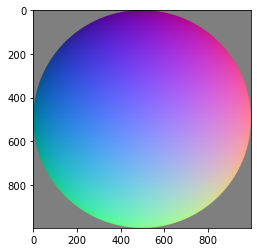

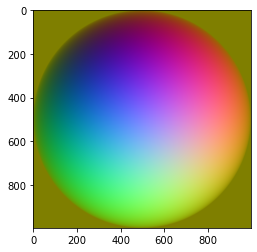

array([[[0.6253831 , 0.6253831 , 0.6253831 ],
        [0.6253831 , 0.6253831 , 0.6253831 ],
        [0.6253831 , 0.6253831 , 0.6253831 ],
        ...,
        [0.6253831 , 0.6253831 , 0.6253831 ],
        [0.6253831 , 0.6253831 , 0.6253831 ],
        [0.6253831 , 0.6253831 , 0.6253831 ]],

       [[0.6532913 , 0.61454403, 0.56978494],
        [0.6536923 , 0.6162813 , 0.5722807 ],
        [0.65370643, 0.61611646, 0.5721739 ],
        ...,
        [0.65356773, 0.6162741 , 0.5720885 ],
        [0.6535131 , 0.61614007, 0.5721739 ],
        [0.6535461 , 0.6162813 , 0.5720442 ]],

       [[0.65263104, 0.61382264, 0.5688448 ],
        [0.65216523, 0.6132835 , 0.5684353 ],
        [0.65211123, 0.614719  , 0.5705937 ],
        ...,
        [0.6522923 , 0.6155012 , 0.5710306 ],
        [0.65211123, 0.614719  , 0.5700128 ],
        [0.65216523, 0.6132835 , 0.5681414 ]],

       ...,

       [[0.2562479 , 0.24442898, 0.26005214],
        [0.25475702, 0.24265745, 0.25744063],
        [0.2543737 , 0

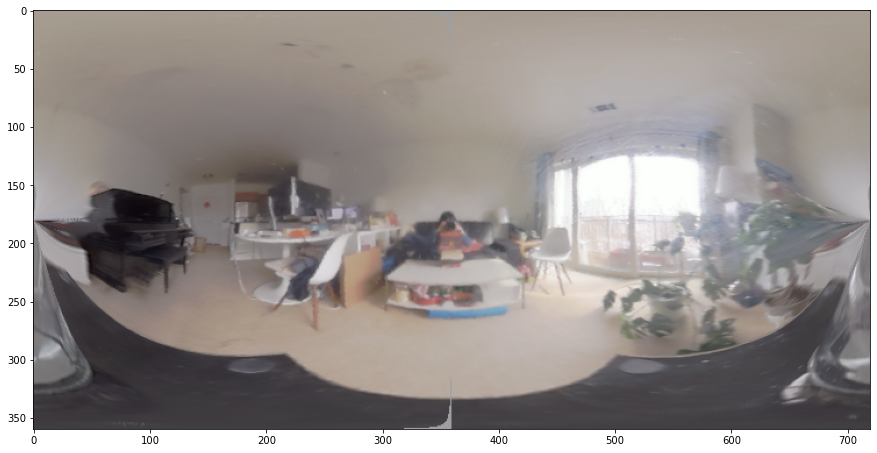

In [200]:
hdr_mirrorball_image = read_hdr_image(datadir + 'calib_hdr.hdr')
eq_image = panoramic_transform(hdr_mirrorball_image)

write_hdr_image(eq_image, datadir + 'equirectangular.hdr')

plt.figure(figsize=(15,15))
display_hdr_image(eq_image)


---

## Rendering synthetic objects into photographs 

Use Blender to render the scene with and with objects and obtain the mask image.  The code below should then load the images and create the final composite.

In [284]:
# Read the images that you produced using Blender.  Modify names as needed.
R = read_image('/Users/marchon/Downloads/proj4/images/proj4_objects.png')
E = read_image('/Users/marchon/Downloads/proj4/images/proj4_empty.png')
M = read_image('/Users/marchon/Downloads/proj4/images/proj4_mask.png')
M = M > 0.5
I = background_image
I = cv2.resize(I, (M.shape[1], M.shape[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


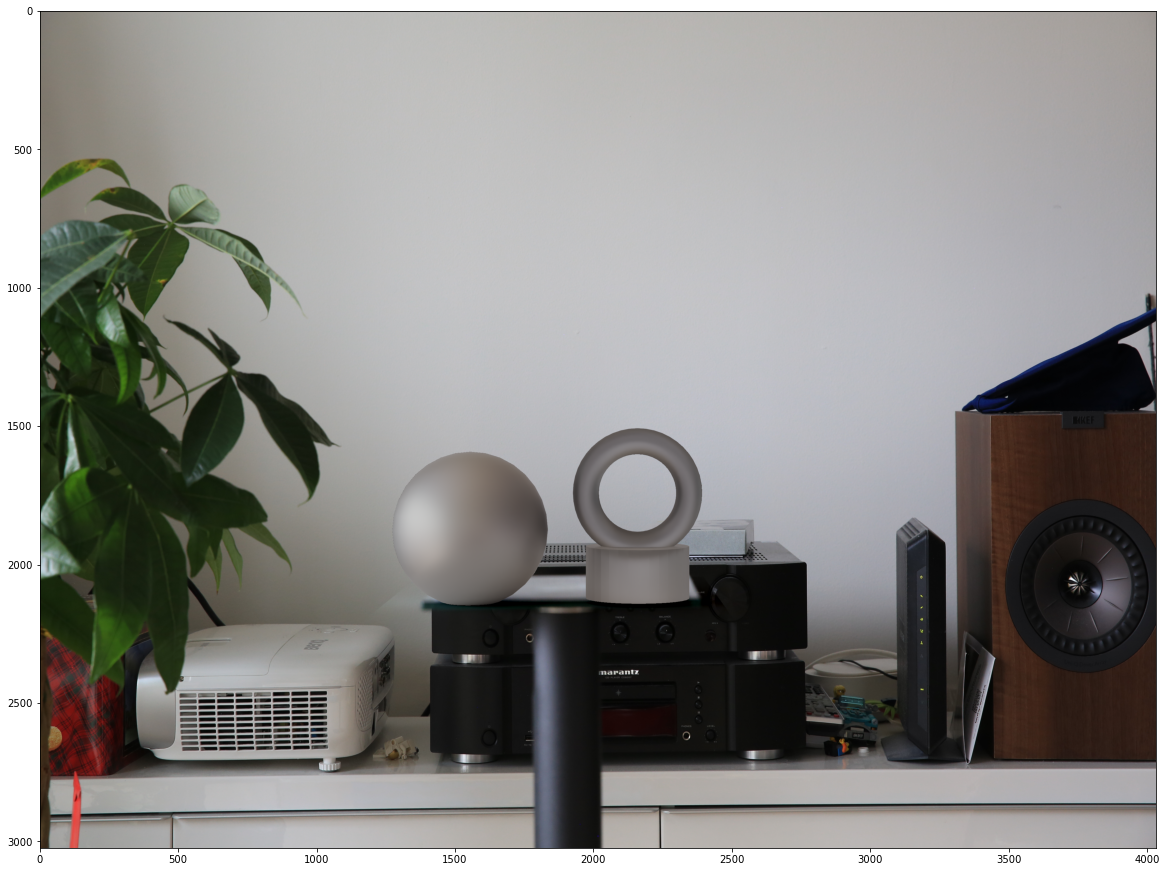

In [285]:
c = 1
result = M * R + (1-M) * I + (1-M) * (R-E) * c

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

write_image(result, datadir + 'final_composite.png')

---

### Additional Results

(1) New objects, same environment map

In [12]:
R = read_image('/Users/marchon/Downloads/proj4/images/proj4_objects1.png')
E = read_image('/Users/marchon/Downloads/proj4/images/proj4_empty1.png')
M = read_image('/Users/marchon/Downloads/proj4/images/proj4_mask1.png')
M = M > 0.5
I = background_image
I = cv2.resize(I, (M.shape[1], M.shape[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


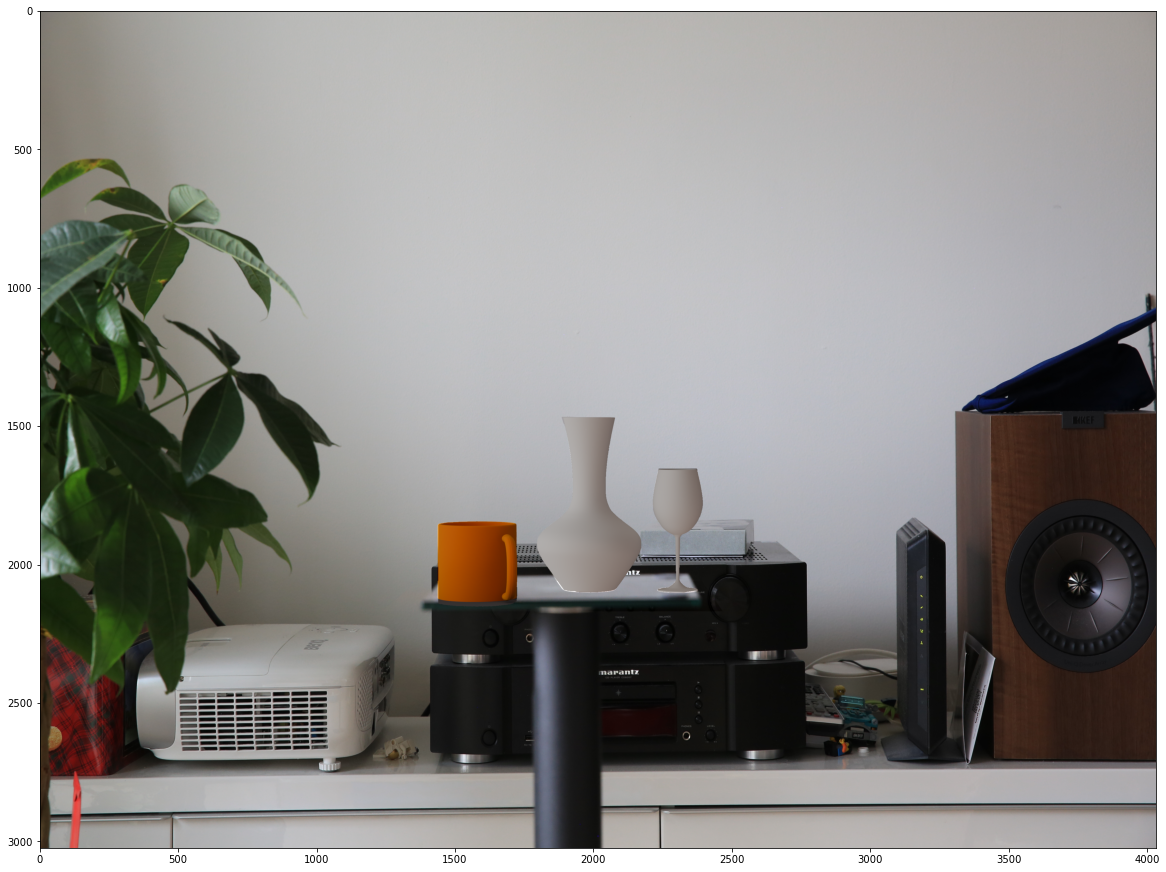

In [13]:
c = 1
result = M * R + (1-M) * I + (1-M) * (R-E) * c

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

write_image(result, datadir + 'final_composite_1.png')